The below constitutes the original song recommendation algorithm followed by the tests done on slider values. The algorithm was updated based on the tests in this notebook, and the final version was converted to SQL; thus, the final algorithm is included in the *team_124_sql_r.zip* file.

It is **not** recommended to run this entire notebook at once, as it will likely take days to complete due to the sheer number of trials run.

In [2]:
import numpy as np
import pandas as pd
from random import seed
from random import random
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [3]:
#Get data

def get_data(path):
    return pd.read_csv(path)

In [4]:
columns = ['danceability', 'energy',
       'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                'popularity', 'time_signature', 'year']

cc = get_data("centroids_top features.csv")
dat = get_data("combined_spotify_full_with labels_top features.csv")

In [5]:
scaler = preprocessing.MinMaxScaler()
data_l = dat[columns]
X_scaled = scaler.fit_transform(data_l)
df_scaled = pd.DataFrame(X_scaled, columns = columns)
    
df_scaled['id'] = dat['id']
df_scaled['k_cluster'] = dat['k_cluster']

In [6]:
#Standardizing data
#Inputs are the full dataset (dataframe) and the selected song (dataframe)
#Output is the standardized dataset, plus the new song,
#without the columns that are unfit for standardization
#We'll probably want filters for "explicit" and "mode" (they both have only 0 and 1 values)

def standardize(data, song):
    
    #If song not in data, add it and assign dummy cluster value
    if song['id'] not in list(data['id']):
        song['k_cluster'] = 100
        data = data.append(song)

    min_max_scaler = preprocessing.MinMaxScaler()
    data_l = data[columns]
    X_scaled = min_max_scaler.fit_transform(data_l)
    df_scaled = pd.DataFrame(X_scaled, columns = columns)
    
    df_scaled['id'] = data['id']
    df_scaled['k_cluster'] = data['k_cluster']
    
    return df_scaled

In [7]:
#Get the cluster assignment for the selected song
#Inputs are the standardized data set, a dataframe containing the standardized cluster centers, 
#and the data for the new song (dataframe)
#Output is the number of the closest cluster

def song_cluster(data_stand, cc, song):
    
    song = data_stand[data_stand['id'] == song['id']].squeeze()
    columns_cc = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'tempo']
    
    if song['k_cluster'] != 100:
        
        return song['k_cluster']
        
    else:

        #Calculates distance between song and each cc.
        distance_calc = np.sqrt(np.sum((cc[columns_cc] - song[columns_cc].squeeze())**2, axis = 1))

        #Zips distance_calc with cluster number and sorts ascending
        sorted_list = sorted(list(zip(cc['k_cluster'], distance_calc)), key = lambda tup: tup[1])

        return sorted_list[0][0]

In [8]:
#Filter dataset to cluster recommended
#Inputs are cluster number and the standardized dataset
#Output is the filtered dataset

def cluster_filter(c_num, sds):
    return sds[(sds['k_cluster'] == c_num) | (sds['k_cluster'] == 100)]


In [9]:

#Get the top ten songs from the selected cluster
#Inputs are the standardized cluster-filtered dataset, the full non-standardized dataset, 
#the chosen song, and the multipliers for each standardized factor
#Output is the list of the top ten songs (all info)


def top_ten(data_cf, data_full, song, dance = 1, energy = 1, key = 1, loud = 1,
             speech = 1, acous = 1, inst = 1, live = 1, val = 1, temp = 1, dur = 1,
             pop = 1, time = 1, year = 1):
    
    #If song not in data_full, add it and assign dummy cluster value
    if song['id'] not in list(data_full['id']):
        song['k_cluster'] = 100
        data_full = data_full.append(song)
        
    #Assign the columns their proper multipliers
    data_cf["danceability"] = data_cf["danceability"] * dance
    data_cf["energy"] = data_cf["energy"] * energy
    data_cf["key"] = data_cf["key"] * key
    data_cf["loudness"] = data_cf["loudness"] * loud
    data_cf["speechiness"] = data_cf["speechiness"] * speech
    data_cf["acousticness"] = data_cf["acousticness"] * acous
    data_cf["instrumentalness"] = data_cf["instrumentalness"] * inst
    data_cf["liveness"] = data_cf["liveness"] * live
    data_cf["valence"] = data_cf["valence"] * val
    data_cf["tempo"] = data_cf["tempo"] * temp
    data_cf["duration_ms"] = data_cf["duration_ms"] * dur
    data_cf["popularity"] = data_cf["popularity"] * pop
    data_cf["time_signature"] = data_cf["time_signature"] * time
    data_cf["year"] = data_cf["year"] * year
     
    #Get the standardized song info
    song = data_cf[data_cf['id'] == song['id']]
        
    distance_calc = np.sqrt(np.sum((data_cf[columns] - song[columns].squeeze())**2, 
                                   axis = 1))
    #.drop('id', axis = 1)
    
    top_10 = sorted(list(zip(distance_calc.index, distance_calc)), key = lambda tup: tup[1])[1:11]
    
    indicies = [i[0] for i in top_10]
    
    data_dist = data_full.iloc[indicies, :]
    data_dist['distance_calc'] = [i[1] for i in top_10]
    
    return data_dist



In [10]:
#Puts all of the preceeding functions together
#Takes as input a path, song, standardized cluster centers,
#and multipliers for standardized factors
#Output is the top ten song recommendations

def all_together(path, song, cc, dance = 1, energy = 1, key = 1, loud = 1,
             speech = 1, acous = 1, inst = 1, live = 1, val = 1, temp = 1, dur = 1,
             pop = 1, time = 1, year = 1):
    data_full = get_data(path)
    data_s = standardize(data_full, song)
    c_num = song_cluster(data_s, cc, song)
    data_cf = cluster_filter(c_num, data_s)
    tt = top_ten(data_cf, data_full, song, dance, energy, key, speech, acous,
              inst, live, val, temp, dur, pop, time, year)
    return tt

In [11]:
#Puts all of the preceeding functions together
#Takes as input the standardized data set, full data set,
#song, standardized cluster centers,
#and multipliers for standardized factors
#Output is the top ten song recommendations

def all_together_2(sds, data_full, song, cc, dance = 1, energy = 1, key = 1, loud = 1,
             speech = 1, acous = 1, inst = 1, live = 1, val = 1, temp = 1, dur = 1,
             pop = 1, time = 1, year = 1):
    c_num = song_cluster(sds, cc, song)
    data_cf = cluster_filter(c_num, sds)
    tt = top_ten(data_cf, data_full, song, dance, energy, key, speech, acous,
              inst, live, val, temp, dur, pop, time, year)
    return tt

In [12]:
#Test

pd.options.mode.chained_assignment = None

ind = dat.iloc[int(random() * len(dat)), :]

all_together_2(df_scaled, dat, ind, cc)

,grp,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,...,liveness,valence,tempo,duration_ms,release_date,popularity,time_signature,year,k_cluster,distance_calc
127215,2544,7uK0BtyoKW6SXWvecYaOpx,Into Darkness,Glowing in Motion,3tf6jacCU38jyjNNExyW8a,['Nina Richards'],['3NngVWg2Gz5n8mt4RARcUh'],5,1,0,...,0.1470,0.1920,110.004,253035,2019-03-01,0,4,2019,2,0.177369
1140814,22816,3fSf7bjUUoqFRbFw5euOTA,Gila Bend,Gila Bend,3ncRZDsuJhOOiBe2m5hfj7,['Afternoon Author'],['5JkOOagkT8GJ6Xupo0UBcA'],1,1,0,...,0.3850,0.0917,89.990,281333,2019-05-10,0,4,2019,2,0.179528
1198818,23976,64DKGh0F0eH0JGUgo0jGKG,Eternal Images,Numb,73veeBVezyrL0zKIe2XVHt,['Martin George Selwood'],['2wgYlIJsogC9KHSSk1tgks'],3,1,0,...,0.0884,0.1560,99.891,282968,2020-09-26,0,4,2020,2,0.201130
369760,7395,1sl34DGuBA95tecJmVap92,Turn All the Clocks Back,Everywhere Is Just a Place,7cDGCl1ko1dGqCnICdqcwZ,['The Divided Circle'],['6oAyKVdmgcgspi3UZfnlEO'],8,1,0,...,0.1440,0.0794,97.900,206327,2013-04-08,0,4,2013,2,0.206021
56162,1123,4kzRMj49QBhxMqAdLvw9wO,The Future Is Black!,Obsidian,4aX3Iln6akQUHwoa4r3dW5,['Simon SMTHNG'],['7EnsuC8mhU75Go15iMN4I1'],3,1,0,...,0.1200,0.1720,119.933,240000,2020-03-20,0,4,2020,2,0.207404
56250,1125,7t488y9wjbXz1HqEHQUM6N,The Future Is Black!,The Future Is Black!,5kVR7myx5CzGWN31b7CXVg,['Simon SMTHNG'],['7EnsuC8mhU75Go15iMN4I1'],1,1,0,...,0.1200,0.1720,119.933,240000,2020-02-29,0,4,2020,2,0.207404
431344,8626,7EojWu8B5HQ2Ee3j0kf4JD,Returning Home,Sacred Black,1sOlV2J1hDvXtZnFWb1qdK,['Amongst Myselves'],['5HVp7Z0k3DFNjlK7aw5PrH'],8,1,0,...,0.0955,0.1330,103.038,280360,2003-01-01,0,4,2003,2,0.211472
956554,19131,7LV6Vc6VIlYpG5Ka8yHJSF,And Then She Saw Stars,Escaping Tomorrow,7ABYxmavLIirzqV5oCOMhm,['Radium88'],['30T6a3wnIDIu7KhKI2QBEp'],14,1,0,...,0.1160,0.0385,116.033,318926,2011-11-01,0,4,2011,2,0.212712
857040,17140,7mmjdsAjhhpP9G5YidUg3t,Shadow Play,Truth Be Told,1x5uRv93EOQpFo5qlxzapn,['Mark Egan'],['6wy22BewtnpjMpQahRiO4b'],6,1,0,...,0.1540,0.2310,79.995,383107,2010-01-31,3,4,2010,2,0.215016
772782,15455,0wVv5pqzZ7kDjUCajkL2PT,Rain In The Face,Kingston Morning,7sQZPJiRBzQpXeQvZzbhfv,['Dave Eggar'],['76H3P1c4PIomESKq0JDiLn'],6,1,0,...,0.0949,0.1460,105.999,357533,2010-08-10,0,4,2010,2,0.216796


-------------------

**Slider Tests**

In [13]:
#make_graph makes a graph based on the results from the following slider tests

import matplotlib.pyplot as plt

def make_graph(res):
    y = list(res[1])
    x = list(res[2])
    plt.plot(x, y)
    plt.xlabel('multiplier')
    plt.ylabel('avg songs changed')

In [14]:
#list of song indicies for testing

song_list = []
for i in range(10):
    song_list.append(int(random() * len(dat)))

Below are the slider tests. There are separate, but basically identical, functions for each feature, which are labeled by feature. 

Each feature function takes as input: 
- a list of song indicies (sl)
- a multiplier value (multi) that creates the list of multiplers to be tested. E.g. a multi value of 1 means that the multiplier values of [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] will be tested. A multi value of 5 means that the multipler values of [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] will be tested.
- A string "upper" or "lower" (ul) that determines whether the upper or lower range (i.e. multipliers above 1 or below 1) will be tested. This input was quickly rendered obsolete, as it was agreed upon that only multipliers greater than or equal to 1 would be in the app. This is why most tests are done on the "upper" range.

Each feature function is designed to compute, for the feature it is named after, the average number of recommended songs changed from the baseline (baseline means every feature has a multiplier of 1), using the songs in sl as selected songs, for the various multiplier values. The other features (i.e. the ones that the function is not named after) have the default multiplier value of 1.

Each feature function returns:
- A list comprised of tuples. Each tuple contains a song index from sl and another list of tuples. Each of these tuples contains a string representing a feature name and multipler, as well as the number of recommended songs changed from the baseline for that multipler and the song index listed earlier.
- The number of recommended songs changed from the baseline, averaged over all of the songs in sl, for each multipler value.
- The list of multiplier values.

Acous

In [15]:
# tester acoustic

def acous_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     acous = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("acoust = {}".format(mult), count_dif))
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list


In [16]:
acous_u_10 = acous_tester(song_list, 10, "upper")
acous_l_10 = acous_tester(song_list, 10, "lower")

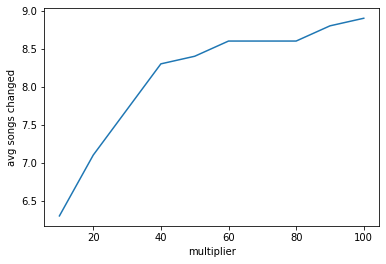

In [17]:
make_graph(acous_u_10)

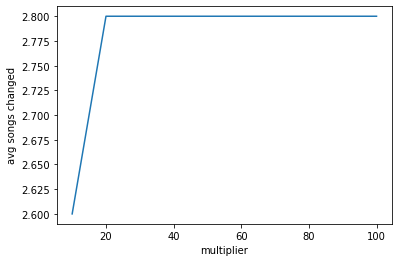

In [18]:
make_graph(acous_l_10)

--------------

Energy

In [19]:
# tester energy

def energy_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     energy = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("energy = {}".format(mult), count_dif))
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list



In [20]:
energy_u_10 = energy_tester(song_list, 10, "upper")
energy_l_10 = energy_tester(song_list, 10, "lower")

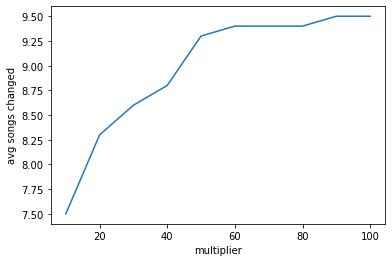

In [21]:
make_graph(energy_u_10)

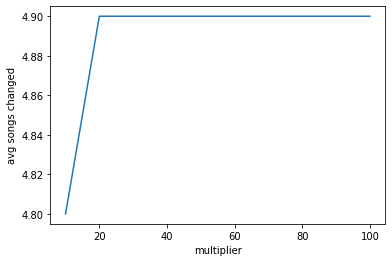

In [22]:
make_graph(energy_l_10)

-------------

Popularity

In [23]:
#Tester Popularity

def pop_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     pop = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("pop = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list



In [24]:
pop_u_10 = pop_tester(song_list, 10, "upper")
pop_l_10 = pop_tester(song_list, 10, "lower")

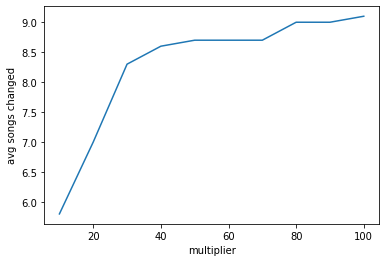

In [25]:
make_graph(pop_u_10)

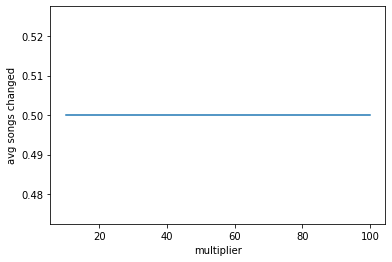

In [26]:
make_graph(pop_l_10)

-------------

Liveness

In [27]:
#Tester Live

def live_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     live = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("live = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list



In [28]:
live_u_10 = live_tester(song_list, 10, "upper")
live_l_10 = live_tester(song_list, 10, "lower")

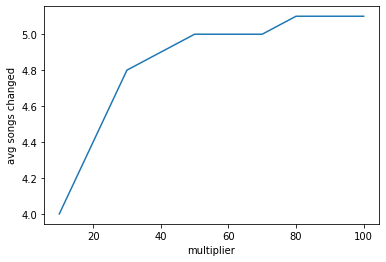

In [29]:
make_graph(live_u_10)

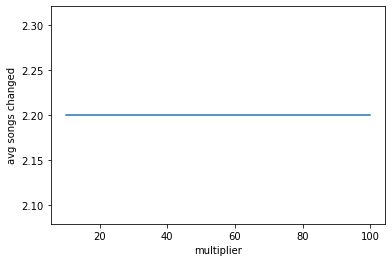

In [30]:
make_graph(live_l_10)

------------

Dance

In [31]:
def dance_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     dance = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("dance = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [32]:
dance_u_10 = dance_tester(song_list, 10, "upper")
dance_l_10 = dance_tester(song_list, 10, "lower")

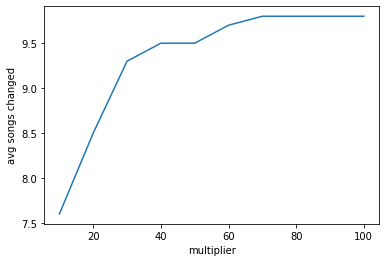

In [33]:
make_graph(dance_u_10)

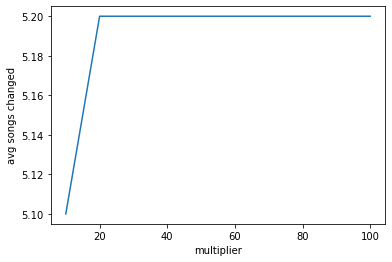

In [34]:
make_graph(dance_l_10)

------------

Key

In [35]:
def key_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     key = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("key = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [36]:
key_u_10 = key_tester(song_list, 10, "upper")
key_l_10 = key_tester(song_list, 10, "lower")

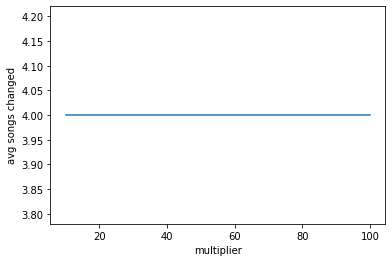

In [37]:
make_graph(key_u_10)

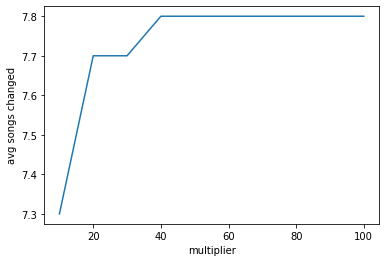

In [38]:
make_graph(key_l_10)

--------------

Loudness

In [39]:
def loud_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     loud = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("loud = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [40]:
loud_u_10 = loud_tester(song_list, 10, "upper")
loud_l_10 = loud_tester(song_list, 10, "lower")

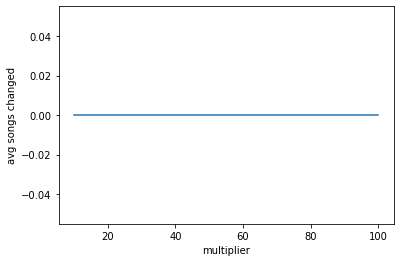

In [41]:
make_graph(loud_u_10)

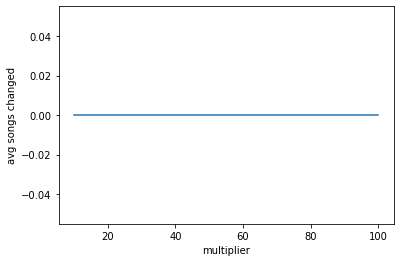

In [42]:
make_graph(loud_l_10)

-----------------

Speech

In [43]:
def speech_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     speech = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("speech = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [44]:
speech_u_10 = speech_tester(song_list, 10, "upper")
speech_l_10 = speech_tester(song_list, 10, "lower")

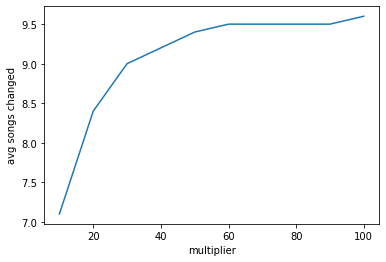

In [45]:
make_graph(speech_u_10)

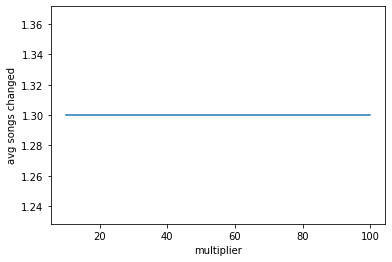

In [46]:
make_graph(speech_l_10)

------------

Instrumentalness

In [15]:
def inst_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     inst = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("inst = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [48]:
inst_u_10 = inst_tester(song_list, 10, "upper")
inst_l_10 = inst_tester(song_list, 10, "lower")

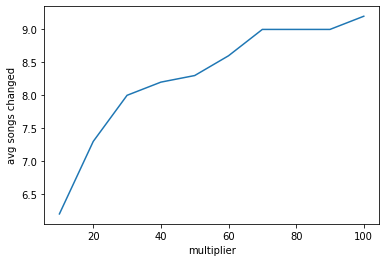

In [49]:
make_graph(inst_u_10)

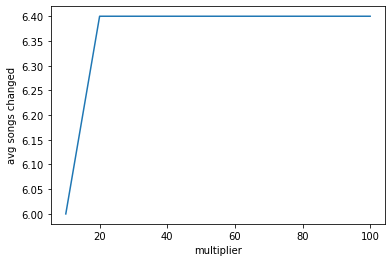

In [50]:
make_graph(inst_l_10)

--------------

Valence

In [51]:
def val_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     val = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("val = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [52]:
val_u_10 = val_tester(song_list, 10, "upper")
val_l_10 = val_tester(song_list, 10, "lower")

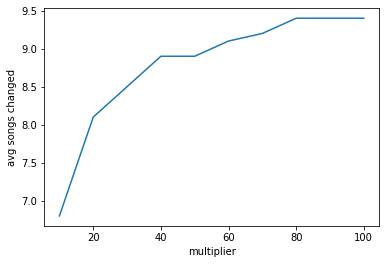

In [53]:
make_graph(val_u_10)

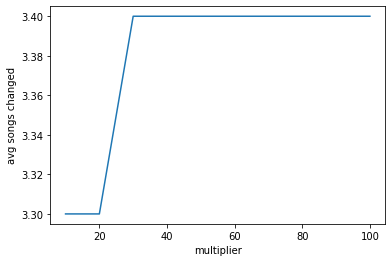

In [54]:
make_graph(val_l_10)

------------

Tempo

In [55]:
def temp_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     temp = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("temp = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [56]:
temp_u_10 = temp_tester(song_list, 10, "upper")
temp_l_10 = temp_tester(song_list, 10, "lower")

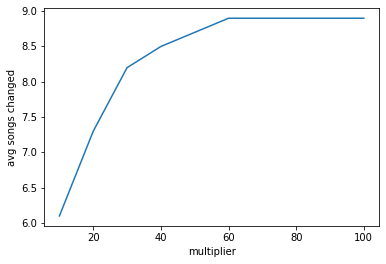

In [57]:
make_graph(temp_u_10)

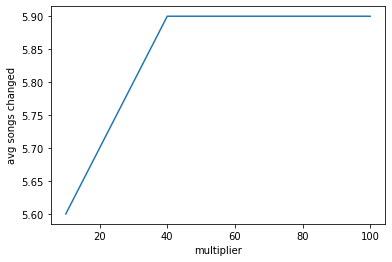

In [58]:
make_graph(temp_l_10)

------------

Duration

In [59]:
def dur_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     dur = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("dur = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [60]:
dur_u_10 = dur_tester(song_list, 10, "upper")
dur_l_10 = dur_tester(song_list, 10, "lower")

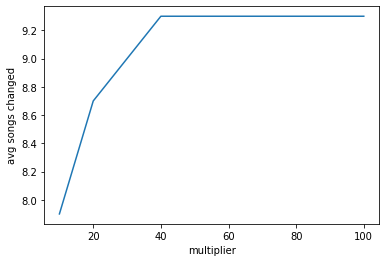

In [61]:
make_graph(dur_u_10)

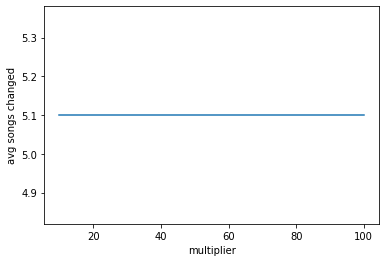

In [62]:
make_graph(dur_l_10)

----------

Time

In [63]:
def time_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     time = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("time = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [64]:
time_u_10 = time_tester(song_list, 10, "upper")
time_l_10 = time_tester(song_list, 10, "lower")

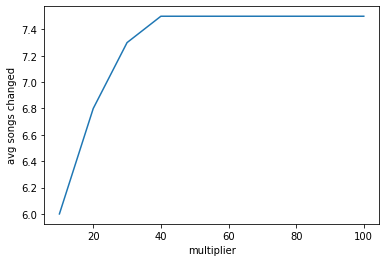

In [65]:
make_graph(time_u_10)

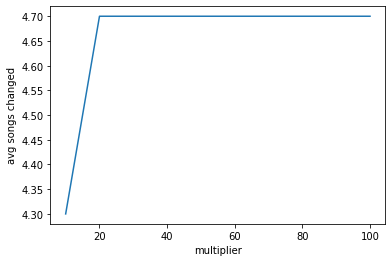

In [66]:
make_graph(time_l_10)

--------------

Year

In [67]:
def year_tester(sl, multi, ul):

    res_list = []
    res_list_avg = []
    mult_list = np.array(range(1,11)) * multi

    for i in range(len(sl)):
        a = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc).squeeze()['id'])

        b_list = []
        for j in range(1,11):
            if ul == "upper":
                mult = j*multi
            elif ul == "lower":
                mult = 1/(j*multi)
            else:
                return "ERROR: ul must equal 'upper' or 'lower'"
            #+ j*multi
            b = list(all_together_2(df_scaled, dat ,dat.iloc[sl[i],:], cc,\
                                     year = mult).squeeze()['id'])
            count_dif = 10 - sum(el in a for el in b)
            b_list.append(("year = {}".format(mult), count_dif))
            
            
        res_list.append((sl[i],b_list))
        res_list_avg.append(np.array([ok[1] for ok in b_list]))
        
    return res_list, np.mean(res_list_avg, axis = 0), mult_list

In [68]:
year_u_10 = year_tester(song_list, 10, "upper")
year_l_10 = year_tester(song_list, 10, "lower")

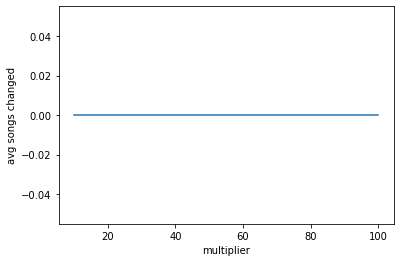

In [69]:
make_graph(year_u_10)

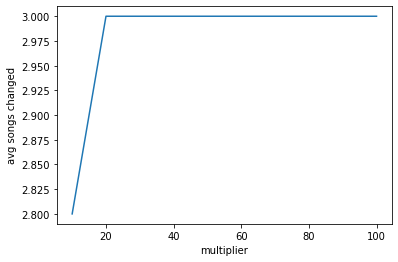

In [70]:
make_graph(year_l_10)

---------------

**Slider Tests 2: multi values of 5 and 10 for upper range**

In [71]:
song_list_2 = []
for i in range(10):
    song_list_2.append(int(random() * len(dat)))

In [72]:
acous_u_10_2 = acous_tester(song_list_2, 10, "upper")
acous_u_5_2 = acous_tester(song_list_2, 5, "upper")

energy_u_10_2 = energy_tester(song_list_2, 10, "upper")
energy_u_5_2 = energy_tester(song_list_2, 5, "upper")

pop_u_10_2 = pop_tester(song_list_2, 10, "upper")
pop_u_5_2 = pop_tester(song_list_2, 5, "upper")

live_u_10_2 = live_tester(song_list_2, 10, "upper")
live_u_5_2 = live_tester(song_list_2, 5, "upper")

dance_u_10_2 = dance_tester(song_list_2, 10, "upper")
dance_u_5_2 = dance_tester(song_list_2, 5, "upper")

key_u_10_2 = key_tester(song_list_2, 10, "upper")
key_u_5_2 = key_tester(song_list_2, 5, "upper")

loud_u_10_2 = loud_tester(song_list_2, 10, "upper")
loud_u_5_2 = loud_tester(song_list_2, 5, "upper")

speech_u_10_2 = speech_tester(song_list_2, 10, "upper")
speech_u_5_2 = speech_tester(song_list_2, 5, "upper")

inst_u_10_2 = inst_tester(song_list_2, 10, "upper")
inst_u_5_2 = inst_tester(song_list_2, 5, "upper")

val_u_10_2 = val_tester(song_list_2, 10, "upper")
val_u_5_2 = val_tester(song_list_2, 5, "upper")

temp_u_10_2 = temp_tester(song_list_2, 10, "upper")
temp_u_5_2 = temp_tester(song_list_2, 5, "upper")

dur_u_10_2 = dur_tester(song_list_2, 10, "upper")
dur_u_5_2 = dur_tester(song_list_2, 5, "upper")

time_u_10_2 = time_tester(song_list_2, 10, "upper")
time_u_5_2 = time_tester(song_list_2, 5, "upper")

year_u_10_2 = year_tester(song_list_2, 10, "upper")
year_u_5_2 = year_tester(song_list_2, 5, "upper")

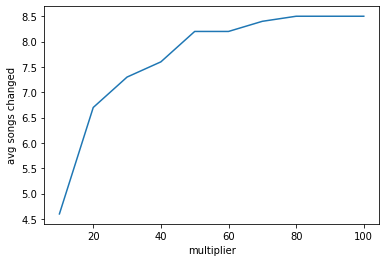

In [112]:
make_graph(acous_u_10_2)

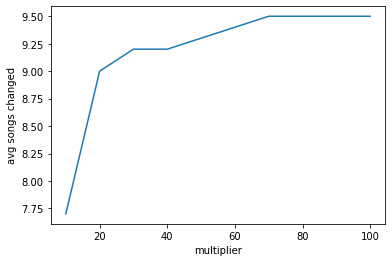

In [113]:
make_graph(energy_u_10_2)

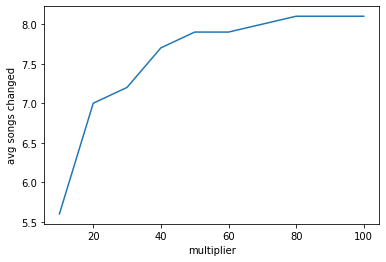

In [114]:
make_graph(pop_u_10_2)

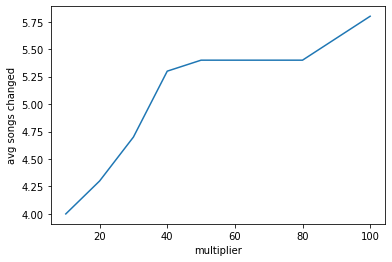

In [115]:
make_graph(live_u_10_2)

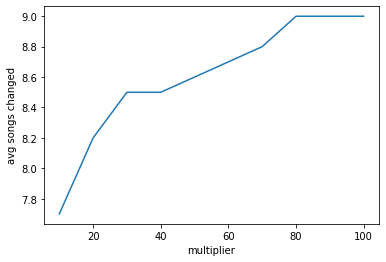

In [116]:
make_graph(dance_u_10_2)

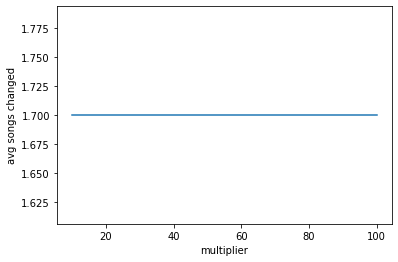

In [117]:
make_graph(key_u_10_2)

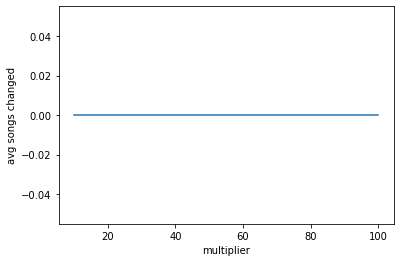

In [118]:
make_graph(loud_u_10_2)

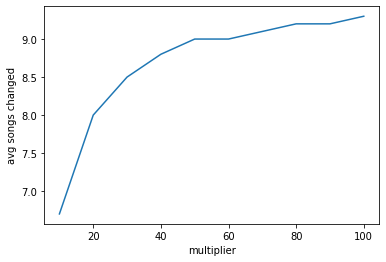

In [119]:
make_graph(speech_u_10_2)

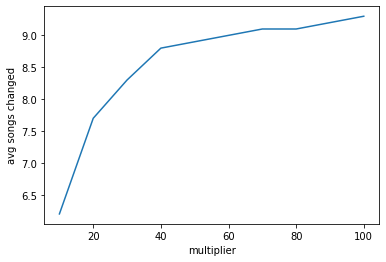

In [120]:
make_graph(inst_u_10_2)

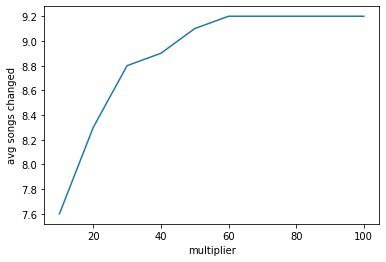

In [121]:
make_graph(val_u_10_2)

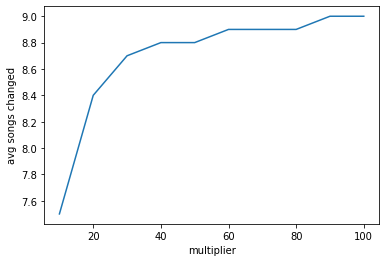

In [122]:
make_graph(temp_u_10_2)

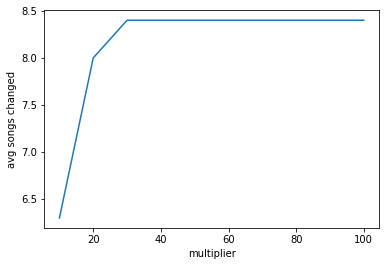

In [123]:
make_graph(time_u_10_2)

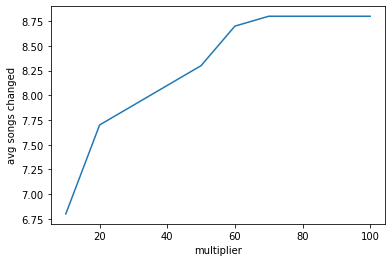

In [124]:
make_graph(dur_u_10_2)

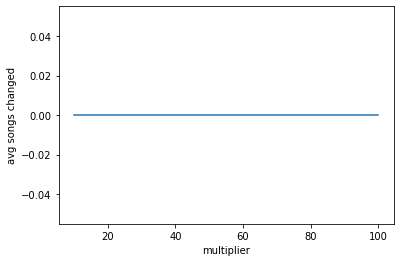

In [125]:
make_graph(year_u_10_2)

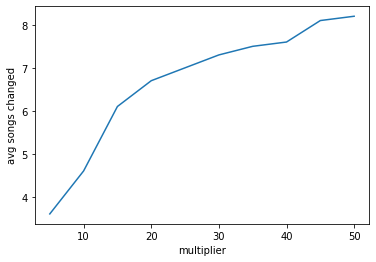

In [126]:
make_graph(acous_u_5_2)

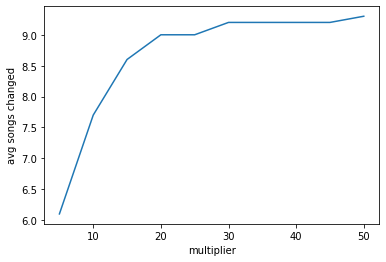

In [130]:
make_graph(energy_u_5_2)

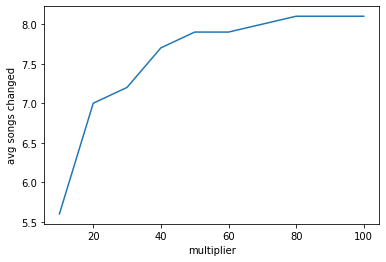

In [133]:
make_graph(pop_u_10_2)

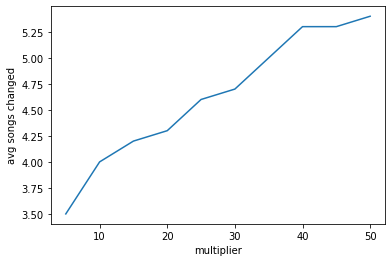

In [134]:
make_graph(live_u_5_2)

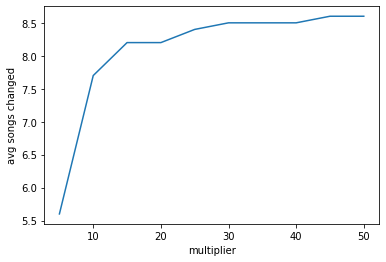

In [135]:
make_graph(dance_u_5_2)

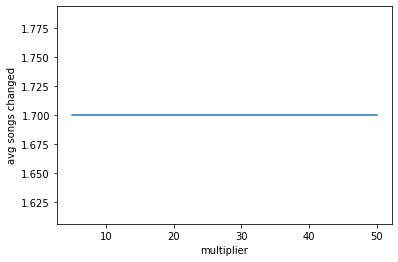

In [136]:
make_graph(key_u_5_2)

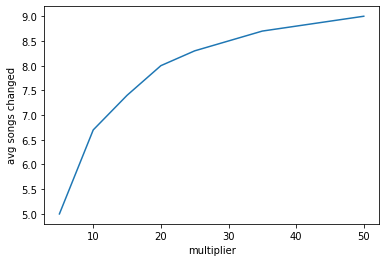

In [137]:
make_graph(speech_u_5_2)

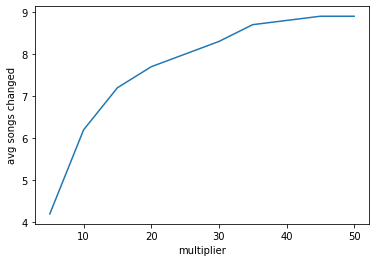

In [138]:
make_graph(inst_u_5_2)

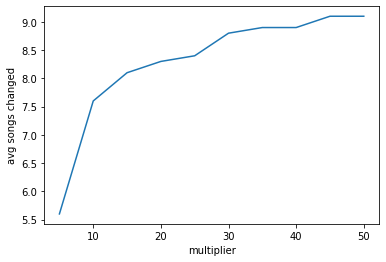

In [139]:
make_graph(val_u_5_2)

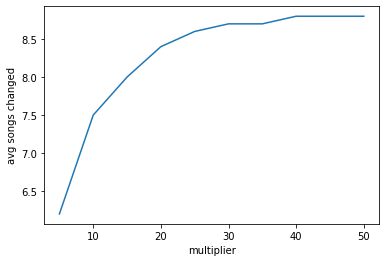

In [140]:
make_graph(temp_u_5_2)

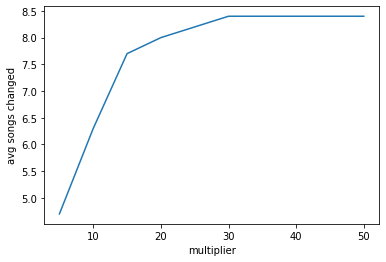

In [141]:
make_graph(time_u_5_2)

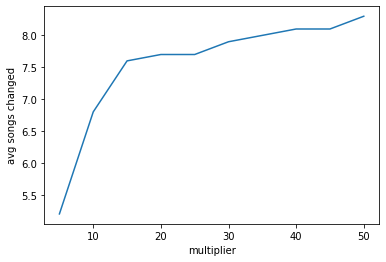

In [142]:
make_graph(dur_u_5_2)

------------

**Slider Tests 3: multi value of 1 for upper range (new song list with 10 songs)**

In [144]:
song_list_3 = []
for i in range(10):
    song_list_3.append(int(random() * len(dat)))

In [145]:
acous_u_1_3 = acous_tester(song_list_3, 1, "upper")

energy_u_1_3 = energy_tester(song_list_3, 1, "upper")

pop_u_1_3 = pop_tester(song_list_3, 1, "upper")

live_u_1_3 = live_tester(song_list_3, 1, "upper")

dance_u_1_3 = dance_tester(song_list_3, 1, "upper")

key_u_1_3 = key_tester(song_list_3, 1, "upper")

loud_u_1_3 = loud_tester(song_list_3, 1, "upper")

speech_u_1_3 = speech_tester(song_list_3, 1, "upper")

inst_u_1_3 = inst_tester(song_list_3, 1, "upper")

val_u_1_3 = val_tester(song_list_3, 1, "upper")

temp_u_1_3 = temp_tester(song_list_3, 1, "upper")

dur_u_1_3 = dur_tester(song_list_3, 1, "upper")

time_u_1_3 = time_tester(song_list_3, 1, "upper")

year_u_1_3 = year_tester(song_list_3, 1, "upper")

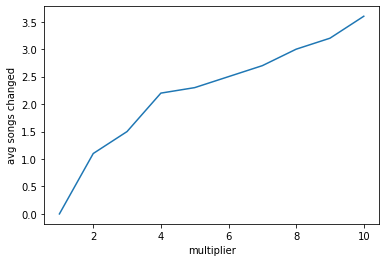

In [146]:
make_graph(acous_u_1_3)

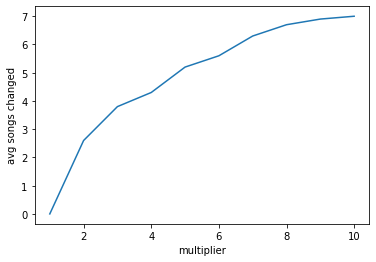

In [147]:
make_graph(energy_u_1_3)

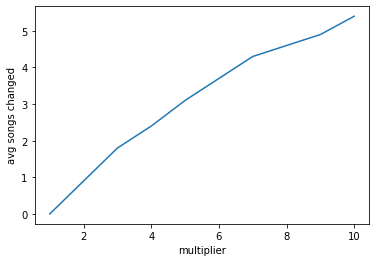

In [148]:
make_graph(pop_u_1_3)

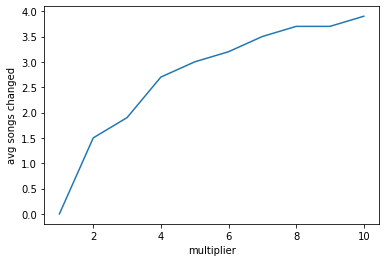

In [149]:
make_graph(live_u_1_3)

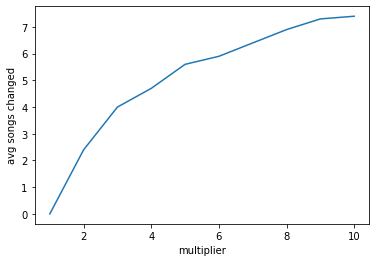

In [150]:
make_graph(dance_u_1_3)

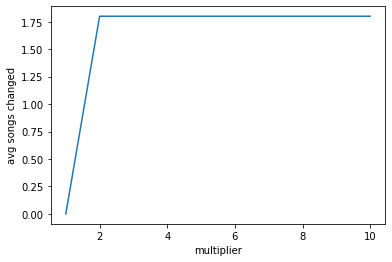

In [151]:
make_graph(key_u_1_3)

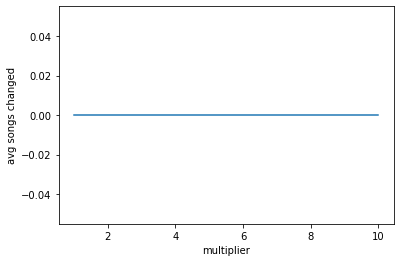

In [152]:
make_graph(loud_u_1_3)

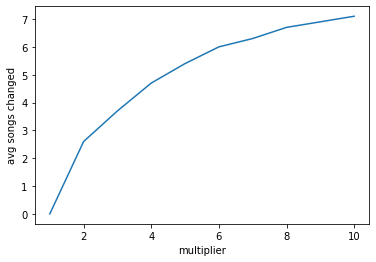

In [153]:
make_graph(speech_u_1_3)

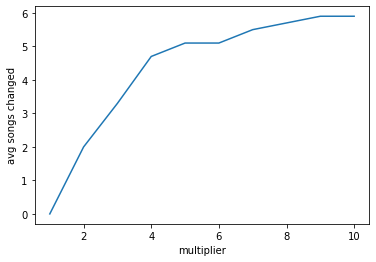

In [154]:
make_graph(inst_u_1_3)

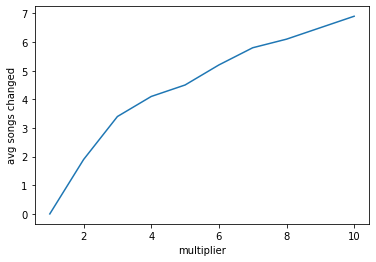

In [155]:
make_graph(val_u_1_3)

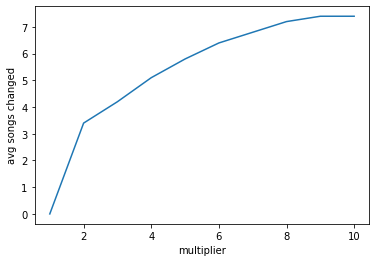

In [156]:
make_graph(temp_u_1_3)

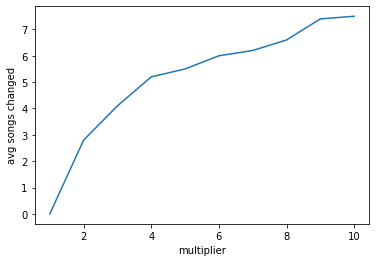

In [157]:
make_graph(dur_u_1_3)

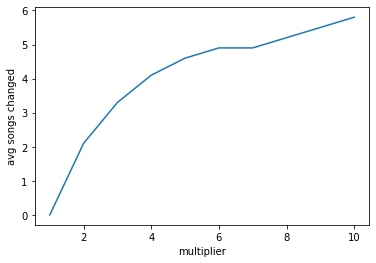

In [158]:
make_graph(time_u_1_3)

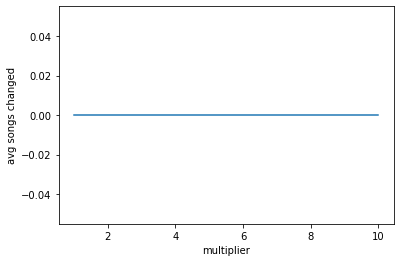

In [159]:
make_graph(year_u_1_3)

----------

**Slider Tests 4: multi value of 1 for upper range (new song list with 100 songs)**

In [16]:
song_list_4 = []
for i in range(100):
    song_list_4.append(int(random() * len(dat)))

In [161]:
acous_u_1_4 = acous_tester(song_list_4, 1, "upper")

energy_u_1_4 = energy_tester(song_list_4, 1, "upper")

pop_u_1_4 = pop_tester(song_list_4, 1, "upper")

live_u_1_4 = live_tester(song_list_4, 1, "upper")

dance_u_1_4 = dance_tester(song_list_4, 1, "upper")

key_u_1_4 = key_tester(song_list_4, 1, "upper")

loud_u_1_4 = loud_tester(song_list_4, 1, "upper")

speech_u_1_4 = speech_tester(song_list_4, 1, "upper")

inst_u_1_4 = inst_tester(song_list_4, 1, "upper")

val_u_1_4 = val_tester(song_list_4, 1, "upper")

temp_u_1_4 = temp_tester(song_list_4, 1, "upper")

dur_u_1_4 = dur_tester(song_list_4, 1, "upper")

time_u_1_4 = time_tester(song_list_4, 1, "upper")

year_u_1_4 = year_tester(song_list_4, 1, "upper")

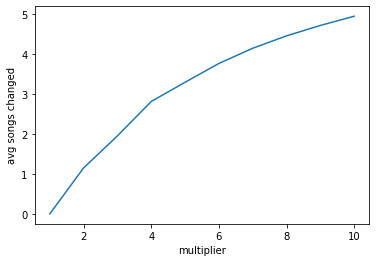

In [163]:
make_graph(acous_u_1_4)

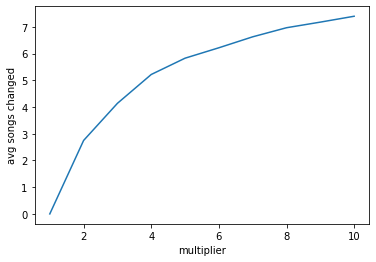

In [164]:
make_graph(energy_u_1_4)

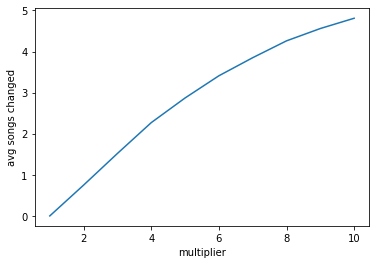

In [165]:
make_graph(pop_u_1_4)

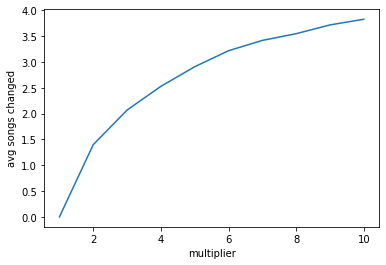

In [166]:
make_graph(live_u_1_4)

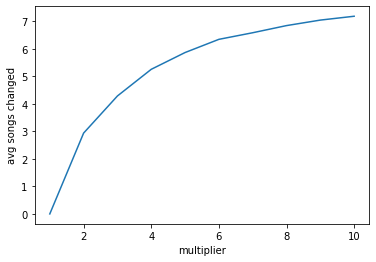

In [167]:
make_graph(dance_u_1_4)

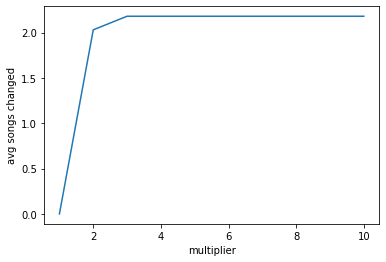

In [168]:
make_graph(key_u_1_4)

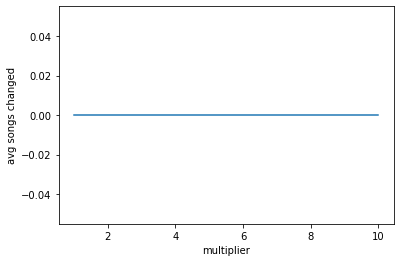

In [169]:
make_graph(loud_u_1_4)

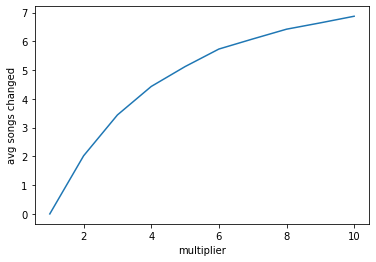

In [170]:
make_graph(speech_u_1_4)

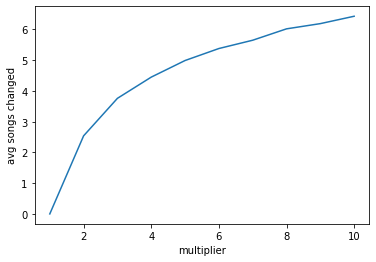

In [171]:
make_graph(inst_u_1_4)

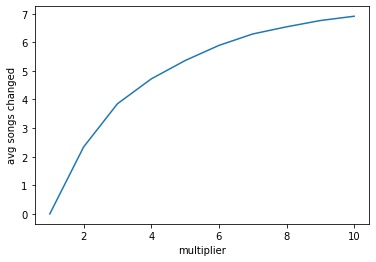

In [172]:
make_graph(val_u_1_4)

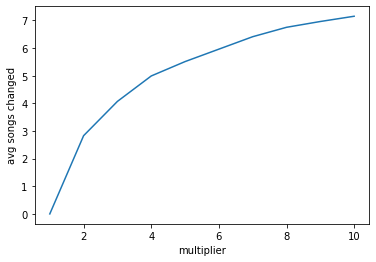

In [173]:
make_graph(temp_u_1_4)

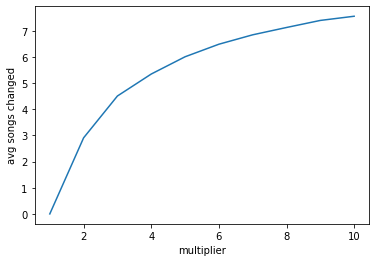

In [174]:
make_graph(dur_u_1_4)

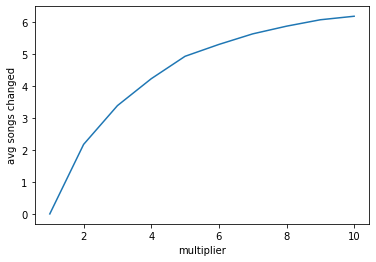

In [175]:
make_graph(time_u_1_4)

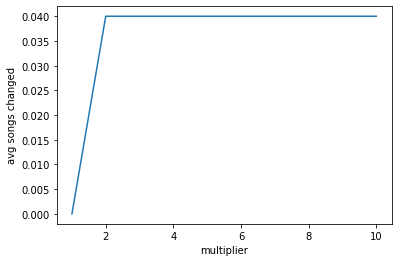

In [176]:
make_graph(year_u_1_4)

-----------

**Graph for report**

In [ ]:
inst_u_1_4 = inst_tester(song_list_4, 1, "upper")

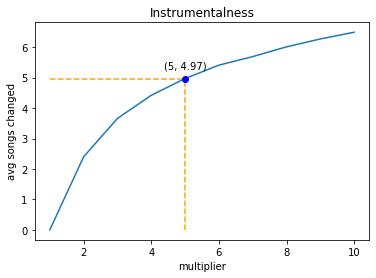

In [35]:
make_graph(inst_u_1_4)
plt.title("Instrumentalness")
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [4.97, 4.97, 4.97, 4.97, 4.97, None, None, None, None, None],\
         color='orange', linestyle='dashed')
plt.plot([5,5,5,5,5,5,5,5,5,5], [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 4.97],\
         color='orange', linestyle='dashed')
plt.annotate('(5, 4.97)', (5, 4.97), textcoords="offset points",\
                 xytext=(0,10), ha='center') 
plt.plot(5,4.97,'bo') 


